# FCD Project: Investigation of the relation between the housing prices and other variables

Content:

[Dataset with house pricing](link)

[Dataset with income data](link)

[Weather API](link)

## Setup

Necessary setup:

- importing the necessary libraries
- the dataset files should be in the same directory as the notebook

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from typing import Dict, List, Tuple, Any


# Set a nice style for our plots
sns.set_style("whitegrid")

warnings.filterwarnings('ignore')


In [13]:
cwd = os.getcwd()

DATA_DIR = os.path.join(cwd, 'data')
PDATA_DIR = os.path.join(DATA_DIR, 'processed')

dirs = (DATA_DIR, PDATA_DIR)

for d in dirs:
    try: os.mkdir(d)
    except: continue

In [20]:
HOUSE_FILE = 'house_pricing_clean.csv'
INCOME_FILE = 'income_clean.csv'
WEATHER_FILE = 'weather_clean.csv'
SERVICES_FILE = ''

## EDA of the dataset of the housing prices information

### Load the raw data and first inspection of the raw data

Data sourse: [Dataset with the average housing prices](https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_destaques&DESTAQUESdest_boui=706274477&DESTAQUEStema=55534&DESTAQUESmodo=2)

In [17]:
filename = 'house_pricing.csv'
file_path = os.path.join(DATA_DIR, filename)

df_raw = pd.read_csv(
    file_path,
    encoding="latin-1",
    sep=';',
    header=None,
    skiprows=3
)
df_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,PT,Portugal,1 066,1 008,972,948,939,938,923,912,...,1 924,1 853,1 801,1 763,1 754,1 724,1 699,1 681,1 639,NaN
1,1,Continente,1 069,1 013,975,951,942,941,926,915,...,1 934,1 864,1 812,1 771,1 763,1 733,1 708,1 692,1 650,NaN
2,11,Norte,1 011,962,921,902,892,889,878,864,...,1 574,1 525,1 488,1 458,1 423,1 382,1 351,1 329,1 289,NaN
3,111,Alto Minho,744,698,690,677,660,654,629,632,...,1 288,1 250,1 205,1 200,1 183,1 162,1 151,1 125,1 113,NaN
4,1111601,Arcos de Valdevez,417,401,404,417,397,408,390,380,...,1 012,1 048,1 000,1 035,1 081,1 035,1 029,975,961,NaN


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       348 non-null    object 
 1   1       347 non-null    object 
 2   2       347 non-null    object 
 3   3       347 non-null    object 
 4   4       347 non-null    object 
 5   5       347 non-null    object 
 6   6       347 non-null    object 
 7   7       347 non-null    object 
 8   8       347 non-null    object 
 9   9       347 non-null    object 
 10  10      347 non-null    object 
 11  11      347 non-null    object 
 12  12      347 non-null    object 
 13  13      347 non-null    object 
 14  14      347 non-null    object 
 15  15      347 non-null    object 
 16  16      347 non-null    object 
 17  17      347 non-null    object 
 18  18      347 non-null    object 
 19  19      347 non-null    object 
 20  20      347 non-null    object 
 21  21      347 non-null    object 
 22  22

As we can see we there's 70 columns and 351 rows (entries). There are 3 core points from the first visual inspection:
1. **Data Quality**
 - There are missing values in most columns (especially in rows like column 0 with 348/351 non-null);
 - Column 70 is entirely missing (0 non-null values) and could likely be dropped;
 - Most other columns are mostly complete, but 4–5 missing values each;

2. **Column Naming**

 - Columns are labeled as numbers (0, 1, ..., 70), because of the headers handled non-standard way in the csv;
 - From the direct inspection of the csv file, we've seen that column names correspond to 'COD (NUTS2024)', 'Designação' and quartile of the years;
 <!-- - One of the next steps is renaming columns for readability and to avoid unnecessary encoding issues we'd chosen english equivalent names; -->

3. **Data Types**

 - 68 out of 71 columns are of type object, from which first column is an id and the next 2 are actual strings;
 - The rest 65 columns are numbers stored as strings, they will be converted to numeric;
 - Only 3 columns are float64, so not much numerical data is immediately usable without cleaning;

How the problems are addressed:

- Missing values: the last column was a full nAn values 
- Column names: after the inspection of the original csv file corresponding header names are added;
- Messy data types: all the numbers represented as strings are converted to numeric data type;

In [21]:
# --- 2. Define Headers ---
location_headers = ['COD (NUTS2024)', 'Designação']

time_headers = [
    '1ºT2025', '4ºT 2024', '3ºT2024', '2ºT2024', '1ºT2024', '4ºT 2023',
    '3ºT2023', '2ºT2023', '1ºT2023', '4ºT 2022', '3ºT 2022', '2ºT2022',
    '1ºT 2022', '4ºT 2021', '3ºT 2021', '2ºT 2021', '1ºT 2021', '4ºT 2020',
    '3ºT 2020', '2ºT 2020', '1ºT 2020', '4ºT 2019'
]

full_headers = location_headers + time_headers

# --- 3. Extract and Build the Median DataFrame ---
df_median = pd.concat([
    df_raw.iloc[:, 0:2],
    df_raw.iloc[:, 25:47]
], axis=1)
df_median.columns = full_headers

# --- 4. Clean and Convert Data Types ---
# Convert quartile columns to numeric
for col in time_headers:
    cleaned_series = df_median[col].astype(str).str.replace(' ', '', regex=False).replace('//', np.nan, regex=False)
    df_median[col] = pd.to_numeric(cleaned_series, errors='coerce')

# --- 5. Impute Missing Values (Targeted Interpolation) ---
# Select only the numeric quartile columns for interpolation
numeric_data = df_median[time_headers].interpolate(method='linear', axis=1, limit_direction='both')
# Fill any remaining NaNs (usually start/end)
numeric_data.fillna(method='ffill', axis=1, inplace=True)
numeric_data.fillna(method='bfill', axis=1, inplace=True)

# Put the imputed numeric data back into the main DataFrame
df_median[time_headers] = numeric_data

# --- 6. Final Setup ---
# Remove footer rows
df_median.dropna(subset=['Designação'], inplace=True)
# Set the index
df_median.set_index('Designação', inplace=True)

# --- 7. Verify the Final Result ---
print("\n--- Final Check for Missing Values ---")
print(f"Total remaining NaNs: {df_median.isnull().sum().sum()}") # Should be 0

print("\n--- Cleaned & Imputed DataFrame Head ---")
df_median.head()


--- Final Check for Missing Values ---
Total remaining NaNs: 66

--- Cleaned & Imputed DataFrame Head ---


,COD (NUTS2024),1ºT2025,4ºT 2024,3ºT2024,2ºT2024,1ºT2024,4ºT 2023,3ºT2023,2ºT2023,1ºT2023,...,1ºT 2022,4ºT 2021,3ºT 2021,2ºT 2021,1ºT 2021,4ºT 2020,3ºT 2020,2ºT 2020,1ºT 2020,4ºT 2019
Designação,,,,,,,,,,,,,,,,,,,,,
Portugal,PT,1845.0,1777.0,1709.0,1661.0,1633.0,1611.0,1579.0,1541.0,1509.0,...,1346.0,1297.0,1251.0,1218.0,1197.0,1190.0,1167.0,1146.0,1127.0,1094.0
Continente,1,1846.0,1778.0,1714.0,1667.0,1638.0,1618.0,1587.0,1550.0,1519.0,...,1351.0,1301.0,1257.0,1222.0,1200.0,1195.0,1169.0,1150.0,1131.0,1096.0
Norte,11,1621.0,1558.0,1492.0,1449.0,1417.0,1394.0,1367.0,1331.0,1304.0,...,1169.0,1133.0,1108.0,1079.0,1065.0,1047.0,1019.0,1000.0,977.0,948.0
Alto Minho,111,1313.0,1248.0,1193.0,1158.0,1124.0,1108.0,1091.0,1077.0,1073.0,...,972.0,945.0,925.0,895.0,893.0,891.0,870.0,865.0,853.0,846.0
Arcos de Valdevez,1111601,960.0,958.0,1000.0,998.0,828.0,813.0,766.0,754.0,760.0,...,690.0,635.0,680.0,705.0,740.0,794.0,711.0,726.0,693.0,672.0


In [19]:
# Drop rows where all time columns are NaN
df_median_final = df_median.dropna(subset=time_headers, how='all')

# Verify that all NaNs are gone
print("\n--- Final Check after Dropping ---")
print(f"Total remaining NaNs: {df_median_final.isnull().sum().sum()}") # Should now be 0

print("\n--- Final DataFrame Head ---")
df_median_final.head()


--- Final Check after Dropping ---
Total remaining NaNs: 0

--- Final DataFrame Head ---


,COD (NUTS2024),1ºT2025,4ºT 2024,3ºT2024,2ºT2024,1ºT2024,4ºT 2023,3ºT2023,2ºT2023,1ºT2023,...,1ºT 2022,4ºT 2021,3ºT 2021,2ºT 2021,1ºT 2021,4ºT 2020,3ºT 2020,2ºT 2020,1ºT 2020,4ºT 2019
Designação,,,,,,,,,,,,,,,,,,,,,
Portugal,PT,1845.0,1777.0,1709.0,1661.0,1633.0,1611.0,1579.0,1541.0,1509.0,...,1346.0,1297.0,1251.0,1218.0,1197.0,1190.0,1167.0,1146.0,1127.0,1094.0
Continente,1,1846.0,1778.0,1714.0,1667.0,1638.0,1618.0,1587.0,1550.0,1519.0,...,1351.0,1301.0,1257.0,1222.0,1200.0,1195.0,1169.0,1150.0,1131.0,1096.0
Norte,11,1621.0,1558.0,1492.0,1449.0,1417.0,1394.0,1367.0,1331.0,1304.0,...,1169.0,1133.0,1108.0,1079.0,1065.0,1047.0,1019.0,1000.0,977.0,948.0
Alto Minho,111,1313.0,1248.0,1193.0,1158.0,1124.0,1108.0,1091.0,1077.0,1073.0,...,972.0,945.0,925.0,895.0,893.0,891.0,870.0,865.0,853.0,846.0
Arcos de Valdevez,1111601,960.0,958.0,1000.0,998.0,828.0,813.0,766.0,754.0,760.0,...,690.0,635.0,680.0,705.0,740.0,794.0,711.0,726.0,693.0,672.0


Saving the clean dataframe.

In [22]:
housing_file = os.path.join(PDATA_DIR, HOUSE_FILE)

df_median_final.to_csv(housing_file, sep=';', encoding='latin-1', index=True)

### The analysis of the prepared data

In [23]:
data = pd.read_csv(housing_file, sep=';', encoding='latin-1', index_col=0)
data.describe()

,1ºT2025,4ºT 2024,3ºT2024,2ºT2024,1ºT2024,4ºT 2023,3ºT2023,2ºT2023,1ºT2023,4ºT 2022,...,1ºT 2022,4ºT 2021,3ºT 2021,2ºT 2021,1ºT 2021,4ºT 2020,3ºT 2020,2ºT 2020,1ºT 2020,4ºT 2019
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,...,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,1203.671512,1159.029070,1117.023256,1089.626453,1069.623062,1056.211240,1038.443314,1015.994961,995.104748,973.903488,...,888.900664,863.521729,839.214790,824.351892,819.887493,808.020477,792.150554,773.787849,758.942829,742.177326
std,755.376021,734.445817,713.333679,701.422601,690.588014,680.167687,664.483806,637.839288,613.699365,590.734743,...,528.576122,507.592595,486.333368,467.967548,455.573072,450.266015,438.905473,432.778769,425.713830,416.743121
min,190.000000,208.000000,220.000000,224.000000,156.000000,156.000000,140.000000,205.000000,143.000000,192.000000,...,177.000000,156.000000,200.000000,189.000000,212.000000,167.000000,167.000000,134.000000,130.000000,156.000000
25%,646.250000,600.500000,579.000000,573.750000,567.250000,563.250000,559.500000,555.000000,560.250000,553.000000,...,505.750000,502.750000,499.041667,495.409091,500.000000,492.250000,479.000000,473.750000,465.500000,459.750000
50%,1000.000000,980.000000,951.500000,928.500000,910.500000,903.500000,881.500000,865.500000,855.000000,838.500000,...,758.000000,751.000000,742.500000,719.500000,733.000000,712.000000,710.500000,704.000000,691.000000,670.000000
75%,1578.250000,1476.000000,1406.750000,1407.000000,1380.500000,1359.500000,1320.750000,1282.500000,1241.250000,1211.250000,...,1119.000000,1054.750000,1015.250000,994.750000,1000.000000,984.000000,964.000000,946.000000,930.500000,904.750000
max,4412.000000,4340.000000,4252.000000,4203.000000,4188.000000,4167.000000,4151.000000,4080.000000,3965.000000,3872.000000,...,3642.000000,3531.000000,3437.000000,3347.000000,3333.000000,3415.000000,3402.000000,3414.000000,3375.000000,3286.000000


#### Descriptive Statistics of Median Prices by Quarter

The table above summarizes key statistical measures for each quarterly column using the `.describe()` method. Each column represents a **specific quarter**, and each row in the summary provides a different statistical metric across all entries (e.g., locations, regions).

##### Columns:
Each column header (e.g., `1ºT2025`, `4ºT2024`, ..., `4ºT2019`) represents a calendar quarter.

##### Metrics Explained:
- **count**: Number of non-null values (344 per quarter) — indicates complete data for each period.
- **mean**: Average median price for that quarter.
- **std**: Standard deviation — measures variability or spread in prices.
- **min / max**: Lowest and highest values — useful for detecting outliers.
- **25% / 50% / 75%**:
  - Represent the first, second (median), and third quartiles.
  - Help understand the distribution and skewness of the data.

##### Observations:
- There is a **consistent increase** in the mean and median values over time, suggesting an **upward trend** in median prices.
- The **standard deviation is relatively high**, indicating substantial variation across regions or categories.
- **Outliers** may be present, as seen in the large gap between the 75th percentile and the maximum value.
- The distribution is likely **right-skewed** (mean > median), with a few very high values pulling the average up.

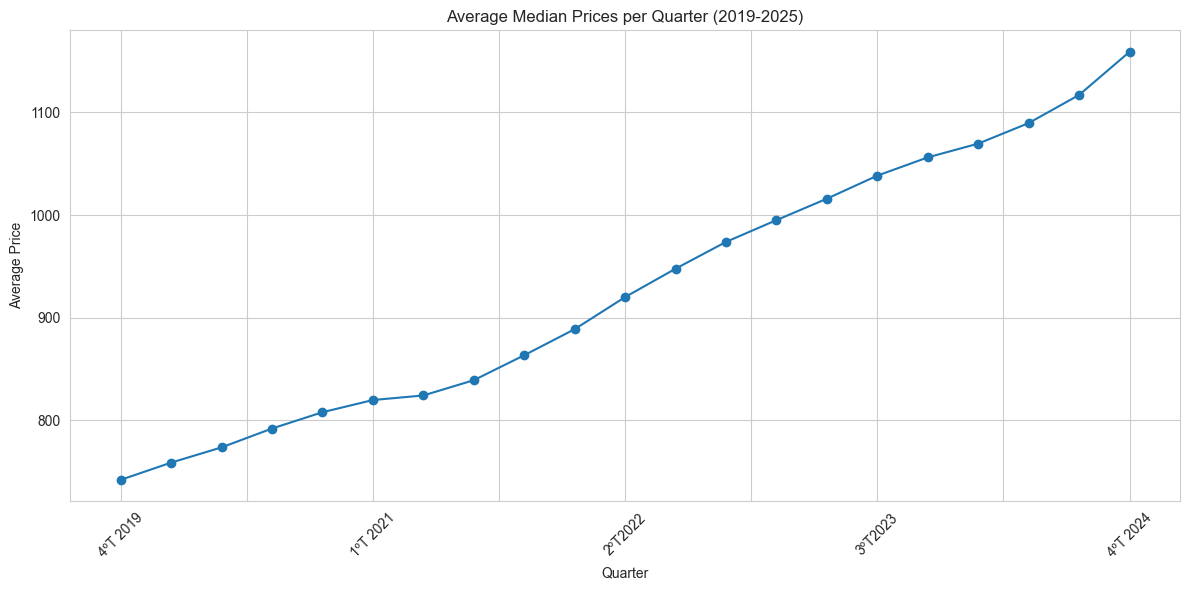

In [24]:
numerical_data = data.iloc[:, 2:]
mean_per_quarter = numerical_data.mean()
mean_per_quarter_sorted = mean_per_quarter.iloc[::-1]

plt.figure(figsize=(12, 6))
mean_per_quarter_sorted.plot(kind='line', marker='o')

plt.title('Average Median Prices per Quarter (2019-2025)')
plt.xlabel('Quarter')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


##### Average Median Prices per Quarter

The line chart above visualizes the **trend of average median prices** over 20 quarters, covering a time span from **Q4 2019 to Q1 2025**.

- The **X-axis** represents time, with each point corresponding to a calendar quarter (e.g., `1ºT2025` = Q1 2025).
- The **Y-axis** shows the average median price across all entries (e.g., regions, categories) for that quarter.
- Each point in the line represents the **mean value** of that quarter, giving a high-level view of how prices evolved over time.

**Key Observations**:
- There is a **clear upward trend**, indicating that median prices have generally increased over the observed period.
- Occasional fluctuations may reflect **seasonality**, **economic shifts**, or **data volatility**.
- The trend may be used as a baseline for **forecasting future prices** or detecting **anomalous quarters**.

> This type of plot is useful for identifying long-term trends and high-level temporal patterns in our data.

Also as an example below is a plot for 4 regions.


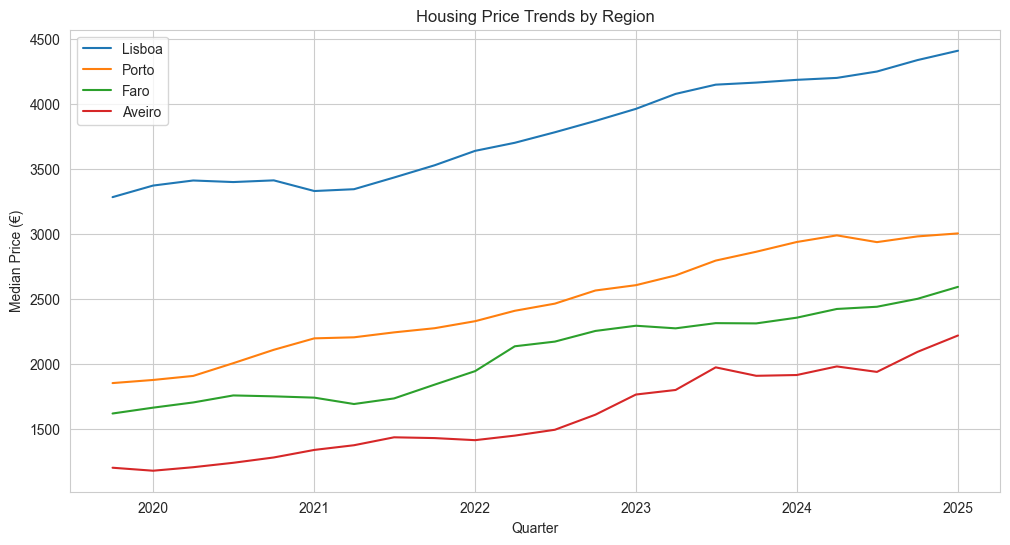

In [25]:
def convert_quarter(quarter_str):
    quarter_str = quarter_str.replace("ºT", "Q").replace(" ", "")
    return pd.Period(quarter_str, freq='Q').to_timestamp()

df_long = df_median.reset_index().melt(
    id_vars=['Designação', 'COD (NUTS2024)'],
    var_name='Quarter',
    value_name='Price'
)
df_long.head()

df_long['Date'] = df_long['Quarter'].apply(convert_quarter)
df_long.head()

regions_to_plot = ['Lisboa', 'Porto', 'Faro', 'Aveiro']  # or any subset
plt.figure(figsize=(12, 6))

for region in regions_to_plot:
    regional_data = df_long[df_long['Designação'] == region]
    plt.plot(regional_data['Date'], regional_data['Price'], label=region)

plt.legend()
plt.title("Housing Price Trends by Region")
plt.xlabel("Quarter")
plt.ylabel("Median Price (€)")
plt.grid(True)
plt.show()

#### Housing Price Trends by Region

The line chart above shows the **evolution of median housing prices** over time for selected regions: **Lisboa, Porto, Faro, and Aveiro**.

##### Data Transformation:
- The data was reshaped from wide to long format using `pd.melt()`, where each row now represents a single region-quarter-price observation.
- The `Quarter` strings (e.g., `1ºT2025`) were converted into proper **datetime objects** using a custom function, allowing the quarters to be plotted on a continuous time axis.

##### Plot Details:
- **X-axis**: Quarters, displayed chronologically from **Q4 2019 to Q1 2025**. Basically year spread.
- **Y-axis**: Median housing prices in euros (€).
- Each line represents a different region, showing how prices changed over time.

##### Observations:
- **Lisboa and Porto** show consistently **higher median prices**, reflecting their status as major urban centers.
- **Faro** also shows an upward trend, possibly influenced by tourism and coastal demand.
- **Aveiro** appears more stable but still shows a gradual increase.
- All regions demonstrate a general **upward trend**, suggesting rising housing prices over the observed period.

> This regional comparison helps identify **geographic disparities**, **growth trends**, and **potential hotspots** for housing price inflation over time.


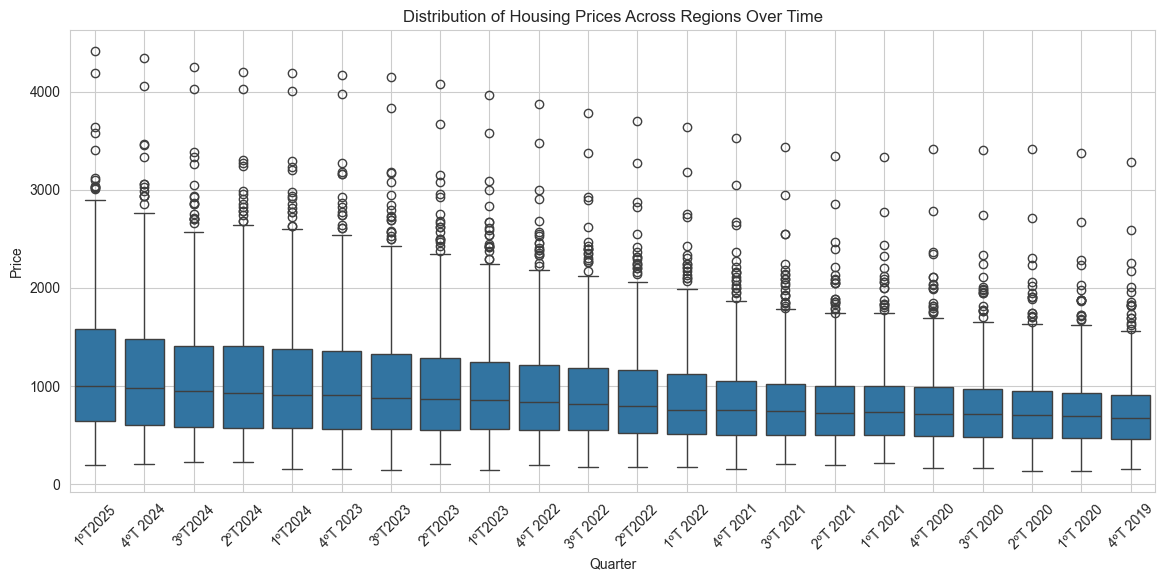

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_long, x='Quarter', y='Price')
plt.title("Distribution of Housing Prices Across Regions Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Boxplot Analysis of Median Prices Across Quarters

The boxplot above visualizes the **distribution of median prices** for each quarter, allowing for a clear comparison of variability, skewness, and potential outliers over time.

##### Key Observations:
- Most quarters show **right-skewed distributions**, where the median line is closer to the bottom of the box and upper whiskers are longer — indicating that a portion of the data has significantly higher values.
- Several quarters contain **visible outliers**, represented as individual points above the whiskers. These may indicate unusually high median prices in some regions or categories.
- The **spread (interquartile range)** tends to increase over time, suggesting growing variability in median prices across the dataset.
- Despite the presence of outliers, the **overall trend in medians** appears to increase steadily, reinforcing the upward trend seen in the mean values.

> This boxplot helps confirm that while prices are rising over time, the data also becomes more spread out and contains extreme values that may need further investigation.


In [27]:
df_long.groupby('Designação')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Designação,,,,,,,,
Abrantes,22.0,562.272727,77.855288,475.0,503.25,538.5,620.75,760.0
Aguiar da Beira,22.0,330.772727,55.989737,253.0,300.00,300.0,357.25,448.0
Alandroal,22.0,498.909091,122.797902,281.0,444.00,500.5,535.50,714.0
Albergaria-a-Velha,22.0,935.772727,145.022472,752.0,811.00,880.0,1072.50,1194.0
Albufeira,22.0,2425.636364,365.222769,1956.0,2065.25,2397.0,2760.50,3040.0
...,...,...,...,...,...,...,...,...
ï¿½bidos,22.0,1554.818182,268.864745,1195.0,1294.25,1575.5,1779.00,2032.0
ï¿½gueda,22.0,858.227273,110.816421,709.0,751.75,867.0,969.50,1032.0
ï¿½lhavo,22.0,1392.181818,268.851638,1047.0,1128.25,1391.5,1674.50,1798.0


#### Regional Summary Statistics of Housing Prices

The table above presents **descriptive statistics** for housing prices grouped by region (`Designação`). Each row summarizes the price data for a region across all observed quarters (typically 22 quarters per region).

##### Metrics Explained:
- **count**: Number of quarterly observations (usually 22, one per quarter)
- **mean**: Average median price across all quarters
- **std**: Standard deviation — how much prices fluctuate over time
- **min / max**: The lowest and highest recorded prices
- **25% / 50% / 75%**: The interquartile range — shows price distribution within the region

---

##### Key Insights & Conclusions:

- **Albufeira** has the highest average price (`€2,425`), with a relatively high standard deviation (`€365`), indicating both **high demand** and **price volatility**, likely due to its touristic appeal.
- **Área Metropolitana do Porto** and **Évora** also stand out with high average prices (`€1,536` and `€1,567` respectively), showing that **urban or historically significant areas** tend to have elevated housing costs.
- **Aguiar da Beira** and **Alandroal** have the lowest mean prices (`€330` and `€498`), suggesting these are **more affordable or rural** markets.
- **Ílhavo**, **Óbidos**, and **Albergaria-a-Velha** show moderately high averages (around `€900–€1,500`) with fairly wide interquartile ranges, reflecting **moderate pricing with variability**, possibly driven by mixed urban-rural characteristics.
- **Standard deviation** varies significantly across regions:
  - Low in **Aguiar da Beira** (`€55.9`) → **stable prices**
  - High in **Albufeira** and **Área Metropolitana do Porto** → **volatile or dynamic markets**

---

> This table helps identify which regions are expensive, stable, volatile, or affordable — all critical for understanding regional housing dynamics and prioritizing areas for deeper analysis or policy focus.


## [EDA of the dataset of the average income](#eda-income)


### Preprocessing

In [36]:
file_path = os.path.join(DATA_DIR, '582.csv')
df = pd.read_csv(file_path, encoding='utf-8') 

In [37]:
df.head()

,01. Ano,02. Nome Região (Portugal),03. Âmbito Geográfico,04. Filtro 1,05. Filtro 2,06. Filtro 3,08. Símbolo,07. Escala,09. Valor
0,2013.0,Portugal,NaN,01. Inferior ao 1.º ciclo,NaN,NaN,x,euros,NaN
1,2013.0,Portugal,NaN,02. Básico - 1º Ciclo,NaN,NaN,x,euros,NaN
2,2013.0,Portugal,NaN,03. Básico - 2º Ciclo,NaN,NaN,x,euros,NaN
3,2013.0,Portugal,NaN,04. Básico - 3º Ciclo,NaN,NaN,x,euros,NaN
4,2013.0,Portugal,NaN,05. Secundário,NaN,NaN,x,euros,NaN


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37393 entries, 0 to 37392
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   01. Ano                     37389 non-null  float64
 1   02. Nome Região (Portugal)  37392 non-null  object 
 2   03. Âmbito Geográfico       37268 non-null  object 
 3   04. Filtro 1                37389 non-null  object 
 4   05. Filtro 2                0 non-null      float64
 5   06. Filtro 3                0 non-null      float64
 6   08. Símbolo                 6210 non-null   object 
 7   07. Escala                  37389 non-null  object 
 8   09. Valor                   31179 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.6+ MB


In [ ]:
new_column_names = {
    '01. Ano': 'Year',
    '02. Nome Região (Portugal)': 'Region',
    '03. Âmbito Geográfico': 'Scope',
    '04. Filtro 1': 'Education_Level',
    '08. Símbolo': 'Symbol',
    '07. Escala': 'Unit',
    '09. Valor': 'Value'
}


df_cleaned = df.rename(columns=new_column_names).drop(columns=['05. Filtro 2', '06. Filtro 3'], errors='ignore')
df_cleaned.head()

,Year,Region,Scope,Education_Level,Symbol,Unit,Value
0,2013.0,Portugal,NaN,01. Inferior ao 1.º ciclo,x,euros,NaN
1,2013.0,Portugal,NaN,02. Básico - 1º Ciclo,x,euros,NaN
2,2013.0,Portugal,NaN,03. Básico - 2º Ciclo,x,euros,NaN
3,2013.0,Portugal,NaN,04. Básico - 3º Ciclo,x,euros,NaN
4,2013.0,Portugal,NaN,05. Secundário,x,euros,NaN


In [43]:
df_cleaned = df_cleaned.dropna(subset=['Value', 'Year', 'Region', 'Scope', 'Education_Level'])
df_cleaned['Year'] = df_cleaned['Year'].astype(int)
df_cleaned['Year'].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [46]:
df_municipal = df_cleaned[df_cleaned['Scope'] == 'Município'].copy() # keep on;y municipal, drop the national
df_municipal['Scope'].unique()

array(['Município'], dtype=object)

In [49]:
df_total_income = df_municipal[df_municipal['Education_Level'] == 'Total'].copy()
total_income_file = os.path.join(PDATA_DIR, 'total_average_income_by_municipality.csv')
df_total_income.to_csv(total_income_file, index=False)

df_total_income.head()

,Year,Region,Scope,Education_Level,Symbol,Unit,Value
131,2013,Abrantes,Município,Total,NaN,euros,1000.8
142,2013,Águeda,Município,Total,NaN,euros,931.4
153,2013,Aguiar da Beira,Município,Total,NaN,euros,703.5
164,2013,Alandroal,Município,Total,NaN,euros,837.4
175,2013,Albergaria-a-Velha,Município,Total,NaN,euros,949.4


In [50]:
df_education_income = df_municipal[df_municipal['Education_Level'] != 'Total'].copy()
avg_income_file = os.path.join(PDATA_DIR, 'average_income_by_education.csv')
df_education_income.to_csv(avg_income_file, index=False)

df_education_income.head()

,Year,Region,Scope,Education_Level,Symbol,Unit,Value
121,2013,Abrantes,Município,01. Inferior ao 1.º ciclo,NaN,euros,612.4
122,2013,Abrantes,Município,02. Básico - 1º Ciclo,NaN,euros,750.0
123,2013,Abrantes,Município,03. Básico - 2º Ciclo,NaN,euros,811.3
124,2013,Abrantes,Município,04. Básico - 3º Ciclo,NaN,euros,832.4
125,2013,Abrantes,Município,05. Secundário,NaN,euros,1011.4


### EDA

In [31]:
df_education_income.head()
df_education_income.info()

print(df_education_income['Value'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 27732 entries, 121 to 37386
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             27732 non-null  int64  
 1   Region           27732 non-null  object 
 2   Scope            27732 non-null  object 
 3   Education_Level  27732 non-null  object 
 4   Symbol           0 non-null      object 
 5   Unit             27732 non-null  object 
 6   Value            27732 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.7+ MB
count    27732.000000
mean      1156.821405
std        492.024660
min          0.000000
25%        823.600000
50%       1000.100000
75%       1378.600000
max       9670.900000
Name: Value, dtype: float64


### What this plot shows
This set of box plots shows the full distribution of incomes for each year from **2015 to 2023**.

---

### Analysis

- We see a clear upward trend. Not only is the **median income** (the center line in each box) rising, but the entire “box” (the 25th to 75th percentile) moves up each year.  
- This confirms that the income growth seen in the **line chart** is happening across the board, not just for a few municipalities.  
- Notice the “dots” above the boxes, especially in later years. These are **outliers** — the handful of very high-income municipalities we saw before. This shows that **income disparity persists** over time.


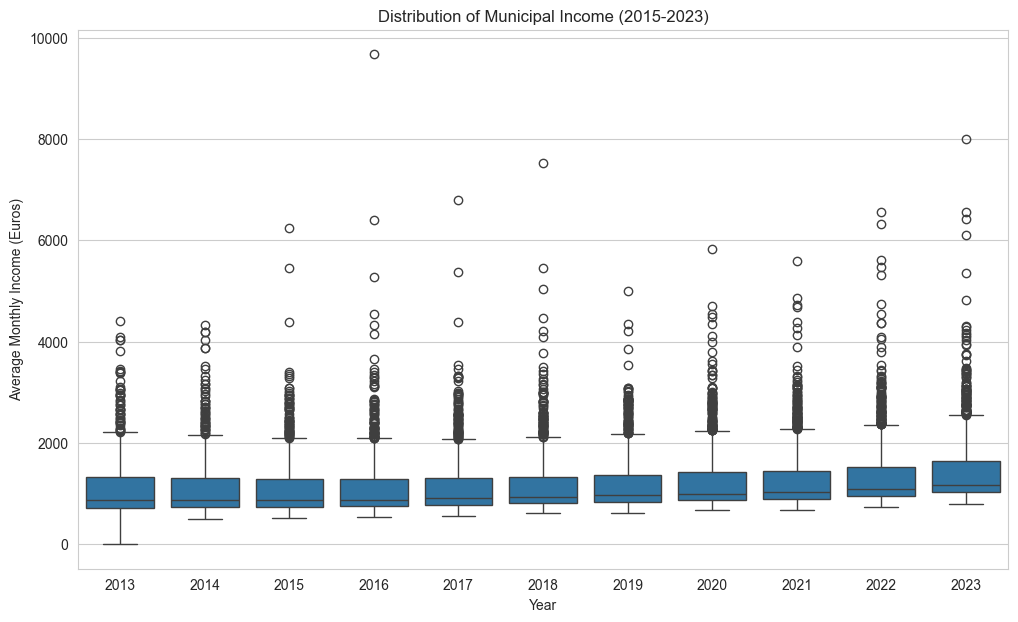

In [32]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_education_income, x='Year', y='Value')

plt.title('Distribution of Municipal Income (2015-2023)')
plt.xlabel('Year')
plt.ylabel('Average Monthly Income (Euros)')
plt.show()

### What this shows
These tables list the **10 highest** and **10 lowest-income municipalities**, based on their **average income** over the entire **2015–2023** period.

---

### Analysis

- This confirms the *“usual suspects.”* We see **Lisboa**, **Oeiras**, and **Porto** are not just rich in one year, but are consistently the **highest-income areas** in the country.  
- Similarly, municipalities like **Penedono** and **Mondim de Basto** appear at the bottom, showing a **persistent lack of high average income**.  
- These **consistent rankings** are more robust for analysis than the **single-year snapshot**.


In [33]:
# Calculate the average income for each municipality across all years
df_consistent_avg = df_education_income.groupby('Region')['Value'].mean().reset_index()

print("\n--- Top 10 Consistently Highest-Income Municipalities (Avg. 2015-2023) ---")
top_10_consistent = df_consistent_avg.sort_values('Value', ascending=False).head(10)
print(top_10_consistent)

print("\n--- Bottom 10 Consistently Lowest-Income Municipalities (Avg. 2015-2023) ---")
bottom_10_consistent = df_consistent_avg.sort_values('Value', ascending=True).head(10)
print(bottom_10_consistent)


--- Top 10 Consistently Highest-Income Municipalities (Avg. 2015-2023) ---
            Region        Value
298  Vila do Porto  2623.422581
243          Sines  2132.132039
70    Castro Verde  2125.857609
7        Alcochete  1889.587234
171         Oeiras  1757.379245
181        Palmela  1642.438679
121         Lisboa  1640.638679
207    Porto Santo  1622.801299
265          Trofa  1587.866038
78      Constância  1557.198718

--- Bottom 10 Consistently Lowest-Income Municipalities (Avg. 2015-2023) ---
                       Region       Value
191                  Penedono  846.433333
215                   Resende  874.233784
52        Cabeceiras de Basto  880.977011
100  Freixo de Espada à Cinta  887.013793
295               Vila de Rei  888.007895
167                      Nisa  894.854651
136                    Marvão  895.770769
41                  Barrancos  895.945455
248                     Sátão  896.243023
72          Celorico de Basto  898.047312


### What this plot shows
This line graph tracks the **average monthly income** across all municipalities from **2015 to 2023**.

---

### Analysis

- This plot confirms the story from our **box plot**: there is a **clear and steady upward trend** in the national average.  
- This is the **“big picture”** trend we will compare against the **“big picture” trend of housing prices**.  
- The next plot will **break this single line down** to see if this growth is **uniform**.


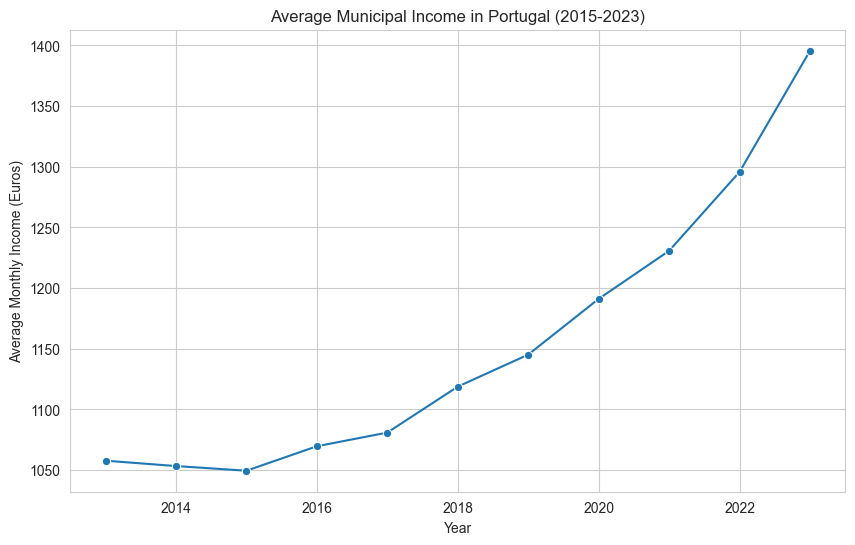

In [34]:
# We group by 'Year' and get the mean of ALL municipalities for that year.
df_avg_by_year = df_education_income.groupby('Year')['Value'].mean().reset_index()

# Plot 2: Line Chart (Evolution)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg_by_year, x='Year', y='Value', marker='o')

plt.title('Average Municipal Income in Portugal (2015-2023)')
plt.xlabel('Year')
plt.ylabel('Average Monthly Income (Euros)')
plt.show()

### What this plot shows
This graph tracks the **individual income paths** for **Lisboa**, **Porto**, and the **consistently highest and lowest-income municipalities**.

---

### Analysis

- The **gap is widening.** While all lines are trending up, the lines for **Lisboa** and **Oeiras** are steeper than the line for **Penedono** (or other low-income areas).  
- This means that in **absolute terms**, high-income areas are gaining **more euros per month each year** than low-income areas.  
- This is a **key insight** for the project: **affordability isn’t just one number; it’s a diverging story.**  
  The affordability challenge in **Lisboa** (where incomes are high, but housing is likely very high) is fundamentally different from the challenge in **Penedono** (where both incomes and housing are low).


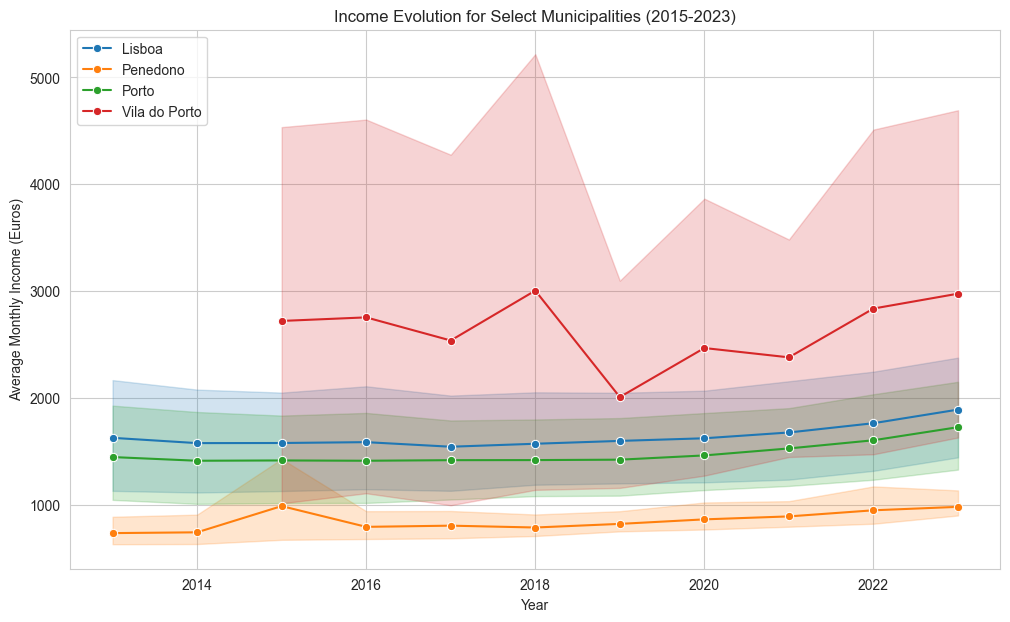

In [35]:
# Let's get the names from the 'consistent' DataFrames we just made
richest_name = top_10_consistent['Region'].iloc[0]
poorest_name = bottom_10_consistent['Region'].iloc[0]

# We'll plot Lisboa, Porto, and the #1 most/least wealthy from our consistent list
mun_to_compare = ['Lisboa', 'Porto', richest_name, poorest_name]
df_compare = df_education_income[df_education_income['Region'].isin(mun_to_compare)]

plt.figure(figsize=(12, 7))
sns.lineplot(data=df_compare, x='Year', y='Value', hue='Region', marker='o')

plt.title(f"Income Evolution for Select Municipalities (2015-2023)")
plt.xlabel('Year')
plt.ylabel('Average Monthly Income (Euros)')
plt.legend()
plt.show()

## [EDA of the dataset of the weather information](#eda-weather)

The data was downloaded from the [Weather open API - Open meteo](https://archive-api.open-meteo.com)
The constructed dataset contains 6 columns: Region name, quarter, average temperature, total precipitation, sunshine duration and average windspeed. 
Run the `weather_fetch.py` first or use the `portugal_weather_quarterly_2019_2025.csv` file.

In [51]:
def read_income_csv(csv_path: str) -> pd.DataFrame:
    """
    Try to read the income CSV with a sensible encoding.
    """
    for enc in ("utf-8", "utf-8-sig", "latin-1"):
        try:
            print(f"Trying encoding: {enc}")
            df = pd.read_csv(csv_path, encoding=enc)
            return df
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError(
        "Could not decode CSV with utf-8 / utf-8-sig / latin-1. "
        "Please check the file encoding."
    )


In [58]:
def get_municipalities_from_income(
    csv_path: str = total_income_file):
    """
    Reads total_average_income_by_municipality.csv and returns the list
    of municipalities from the 'Region' column with:
      - Scope == 'Município'
      - Education_Level == 'Total'
    (across all years)
    """
    df = read_income_csv(csv_path)
    # print("Columns found in income CSV:", list(df.columns))

    required_cols = {"Region", "Scope", "Education_Level"}
    if not required_cols.issubset(df.columns):
        raise KeyError(
            f"CSV must contain columns {required_cols}, "
            f"but has {set(df.columns)}"
        )

    # Filter to municipality scope + total education
    muni_df = df[
        (df["Scope"] == "Município") &
        (df["Education_Level"] == "Total")
    ]

    municipalities = sorted(muni_df["Region"].dropna().unique())
    print(f"Found {len(municipalities)} municipalities in income CSV.")
    print("Example municipalities:", municipalities[:5])

    return municipalities

In [59]:
municipalities = get_municipalities_from_income()

Trying encoding: utf-8
Found 308 municipalities in income CSV.
Example municipalities: ['Abrantes', 'Aguiar da Beira', 'Alandroal', 'Albergaria-a-Velha', 'Albufeira']


In [61]:
import unicodedata
def strip_accents(s: str) -> str:
    """
    Remove accents from a Unicode string.
    'Águeda' -> 'Agueda'
    """
    if not isinstance(s, str):
        return s
    nfkd = unicodedata.normalize("NFD", s)
    return "".join(ch for ch in nfkd if unicodedata.category(ch) != "Mn")


In [4]:
weather_file = "portugal_weather_quarterly_2019_2025.csv"
weather_df = pd.read_csv(weather_file)
weather_df.head()

,region,quarter,temperature_2m_mean,precipitation_sum,sunshine_duration,windspeed_10m_mean
0,Norte,2019Q1,7.940000,260.8,2574408.01,9.866667
1,Norte,2019Q2,13.502198,367.8,3463017.97,9.482418
2,Norte,2019Q3,19.126087,105.7,3747818.36,8.069565
3,Norte,2019Q4,10.657609,989.3,1844647.58,10.970652
4,Norte,2020Q1,8.982418,399.6,2348701.24,10.001099


The weather data we have can be used to explore, whether the weather affects the housing prices, for example, do sunnier regions have higher property prices or does rainfall correlate with lower prices. Later on the weather dataset can be merged with the average house pricing dataset. The weather data is collected in such a way that it  chnologically corresponds to the housing prices dataset time range. Below is a list of possible questions to explore regarding the possible connection between the change in weather and house pricing.

| Question                                                                                         | What to Explore                                        |
| ------------------------------------------------------------------------------------------------ | ------------------------------------------------------ |
| Do sunnier regions have higher property prices?                                               | Compare average sunshine duration vs. average price    |
| Does rainfall correlate with lower prices or slower growth?                                   | Regression of quarterly price change vs. precipitation |
| Are milder climates linked to premium real estate?                                            | Compare temperature ranges to prices                   |
| Are coastal windy areas priced differently?                                                   | Correlate windspeed with coastal property prices       |
<!-- | How do seasonal weather patterns affect short-term rental markets (and thus property prices)? | Combine quarterly weather and Airbnb/occupancy data    | -->


In [5]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   region               175 non-null    object 
 1   quarter              175 non-null    object 
 2   temperature_2m_mean  175 non-null    float64
 3   precipitation_sum    175 non-null    float64
 4   sunshine_duration    175 non-null    float64
 5   windspeed_10m_mean   175 non-null    float64
dtypes: float64(4), object(2)
memory usage: 8.3+ KB


Fortunately, as we can see there's no missing data, so we won't need to handle the missing values. As for the columns we have 6 of them, 2 are string values and 4 are numerical. 
1. **region** indicates a region in Portugal;
2. **quarter** that corresponds to the quarter of the year in a format 'yearQ[number from 1 to 4]'. This part will be changed when the merging with house pricing will take place;
3. **temperature** is a mean temperature in Celcius in the given region and quarter;
4. **precipitation** is a sum of precipitations in the given region and quarter, given in mm;
5. **sunshine** is a sum of sunlight duration throught the quarter in a given region, given in seconds;
6. **windspeed** is a mean wind speed across the quarter in a given region, given in km/h.

In [6]:
weather_df.describe()

,temperature_2m_mean,precipitation_sum,sunshine_duration,windspeed_10m_mean
count,175.000000,175.000000,1.750000e+02,175.000000
mean,15.613366,245.593714,3.067421e+06,11.048944
std,4.572461,194.500520,6.782262e+05,3.524397
min,6.881111,8.800000,1.775403e+06,3.311957
25%,12.063016,91.050000,2.441438e+06,9.788587
50%,14.939560,200.700000,2.840888e+06,11.215385
75%,18.868132,373.300000,3.763520e+06,13.246667
max,25.242391,1065.200000,4.031094e+06,21.804444


Above is a Tukey five number summary for the collected data. Though I strongly believe that the general overview is irrelevant at this point, the region-based summary has more value for the purposes of the project. So below is a Tukey five number summary for the North region in general.

In [7]:
# choose the North region for detailed summary
north_weather = weather_df[weather_df['region'] == 'Norte'] 
north_weather.describe()

,temperature_2m_mean,precipitation_sum,sunshine_duration,windspeed_10m_mean
count,25.000000,25.00000,2.500000e+01,25.000000
mean,13.281844,406.27600,2.893338e+06,9.444451
std,4.365668,282.68081,7.818858e+05,1.040243
min,7.940000,86.40000,1.775403e+06,7.789130
25%,8.982418,192.30000,2.173250e+06,8.479348
50%,12.184783,318.80000,2.574408e+06,9.750000
75%,16.034066,521.60000,3.654463e+06,10.013043
max,20.640217,1065.20000,3.881265e+06,11.070330


So here we can see all the statistical summary for each of the numerical data we have. All the other regions can be analyzed in the same manner and considering that the datasets will be merged, the analysis of one region should be considered more than enough for the EDA of the weather data in general.

---

As for the North region we have 25 samples (20 quarters for 5 years from 2019 to 2024 plus the first quarter of the 2025). Same amount of rows is for each region in the dataset. We can see that:

1. Temperature:
    - range is from 7.94 to 20.64 degrees, so we can see that the region had mild temperatures;
    - mean is 13.28 and median is 12.18, the difference is 1 degree, so we can assume that the data is a bit right-skewed;
    - the standard deviation is 4.37, which is not a lot, considering that the temperature range is in the mild spectrum, so we can suggest that most of the spread is from 8.91 to 17.55 degrees (13.28 ± 4.37);
    - the Q1(8.98) and the Q3(16.03) give us the understanding that 50% of the data is within these two values, which also almost corresponds to the variability-based conclusion;

2. Precipitation
    - the range is from 86.40 mm to 1065.20 mm per quarter, the contrast can be explained with the season change (summer vs winter);
    - the median (318.8 mm) is again below the mean (406 mm), implying a right-skewed distribution — a few unusually wet quarters raise the average;
    - the substantial variability is described by the quite large standard deviation (282.68 mm) compared to the mean (~70%), which indicates large seasonal flustuations;
    - the Q1(521, 6) and the Q3(192.3) imply that 50% of the data is within this range, implying high spread even among typical quarters;
3. Sunlight
    - The mean corresponds to roughly 9 hours of sunshine per day (2.89 million s ÷ (90 days × 3600 s/h) ≈ 8.9 h/day);
    - The min corresponds to ~5.5 h/day; the max to ~12 h/day which fits natural seasonal daylight variation (winter vs. summer);
    - The distribution is likely left-skewed (many lower-sunshine quarters, a few with extremely high sunshine). Overall high variability but no extreme outliers;
    - 25–75% range (≈ 2.17 – 3.65 million s) shows a big seasonal daylight swing;
4. Wind speed
    - the standard deviation is only ~11% of the mean, which implies that the wind speed is quite table;
    - slight left skew (median > mean), meaning most quarters are moderately windy, with a few calmer ones;
    - no major outliers or volatility, so the wond conditions are relatively constistent across quarters with minor seasonal variation.

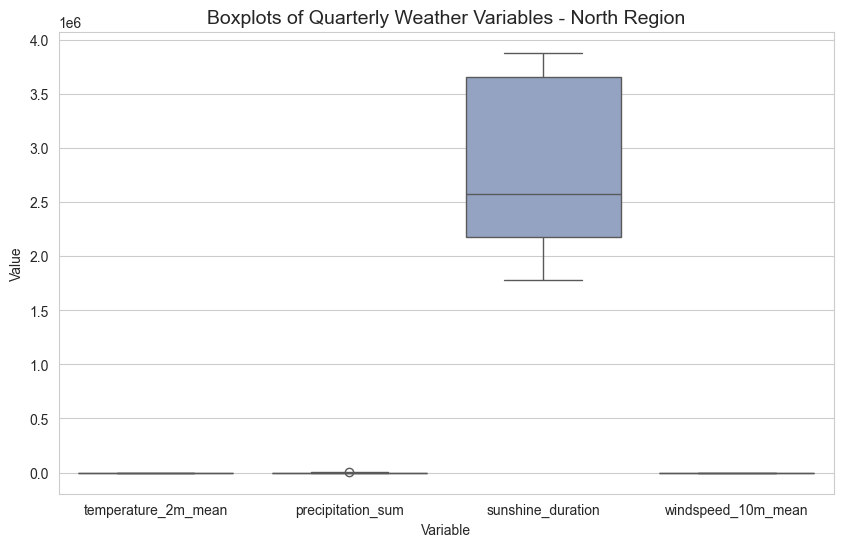

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=north_weather, palette="Set2")
plt.title("Boxplots of Quarterly Weather Variables - North Region", fontsize=14)
plt.ylabel("Value")
plt.xlabel("Variable")
plt.show()


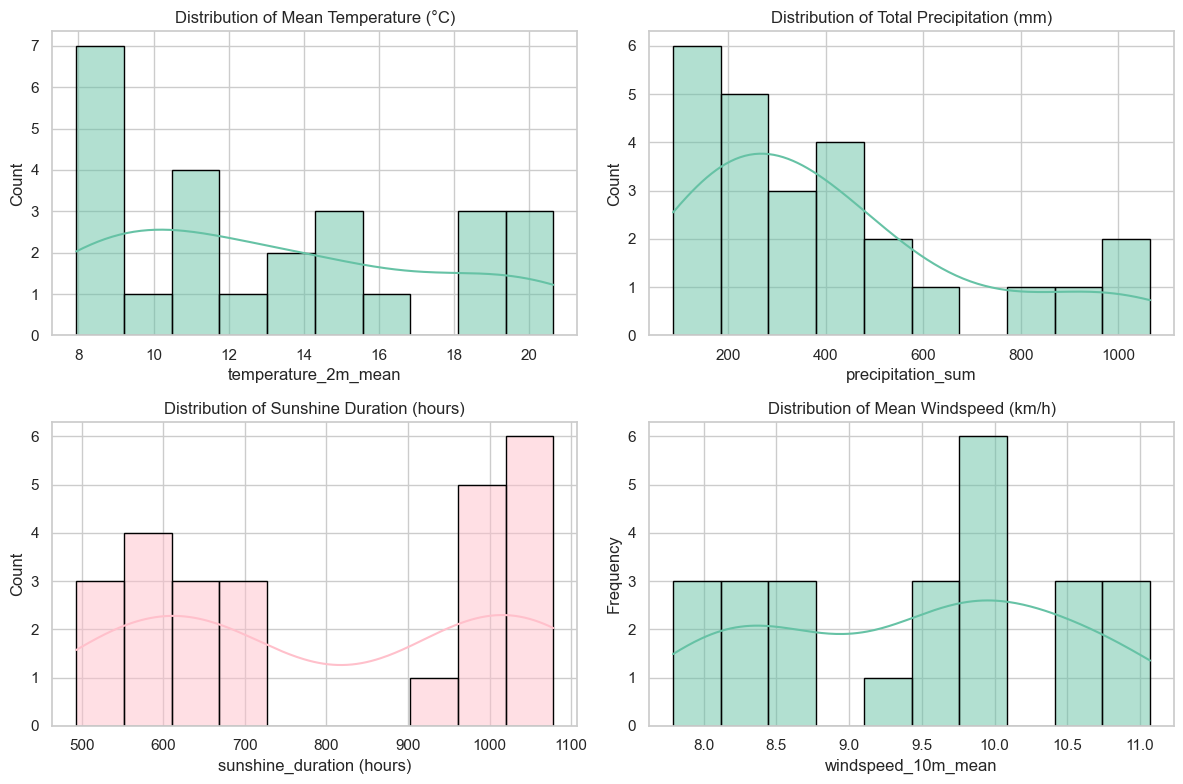

In [9]:
cols = ["temperature_2m_mean", "precipitation_sum", "sunshine_duration", "windspeed_10m_mean"]
plot_titles = {
    "temperature_2m_mean": "Distribution of Mean Temperature (°C)",
    "precipitation_sum": "Distribution of Total Precipitation (mm)",
    "sunshine_duration": "Distribution of Sunshine Duration (hours)",
    "windspeed_10m_mean": "Distribution of Mean Windspeed (km/h)"
}
data = north_weather[cols]

sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(12, 8))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    if col == "sunshine_duration":
        sns.histplot(data[col] / 3600, bins=10, kde=True, color="pink", edgecolor="black")  # Convert seconds to hours
        plt.title(plot_titles[col])
        plt.xlabel(f"{col} (hours)")
    else:
        sns.histplot(data[col], bins=10, kde=True, edgecolor="black")
        plt.title(plot_titles[col])
        plt.xlabel(col)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [10]:
north_weather.iloc[:, 2:].corr()

,temperature_2m_mean,precipitation_sum,sunshine_duration,windspeed_10m_mean
temperature_2m_mean,1.000000,-0.573648,0.855465,-0.856414
precipitation_sum,-0.573648,1.000000,-0.827341,0.810429
sunshine_duration,0.855465,-0.827341,1.000000,-0.896314
windspeed_10m_mean,-0.856414,0.810429,-0.896314,1.000000


From the correlation matrix above can see that
| Relationship                | Strength    | Direction | Interpretation         |
| --------------------------- | ----------- | --------- | ---------------------- |
| Temperature - Sunshine      | Strong      | Positive  | Warm = sunny           |
| Temperature - Precipitation | Moderate    | Negative  | Warm = dry, Cool = wet |
| Temperature - Windspeed     | Strong      | Negative  | Cool = windy           |
| Precipitation - Sunshine    | Strong      | Negative  | Rainy = cloudy         |
| Precipitation - Windspeed   | Strong      | Positive  | Rainy = windy          |
| Sunshine - Windspeed        | Very Strong | Negative  | Windy = less sun       |


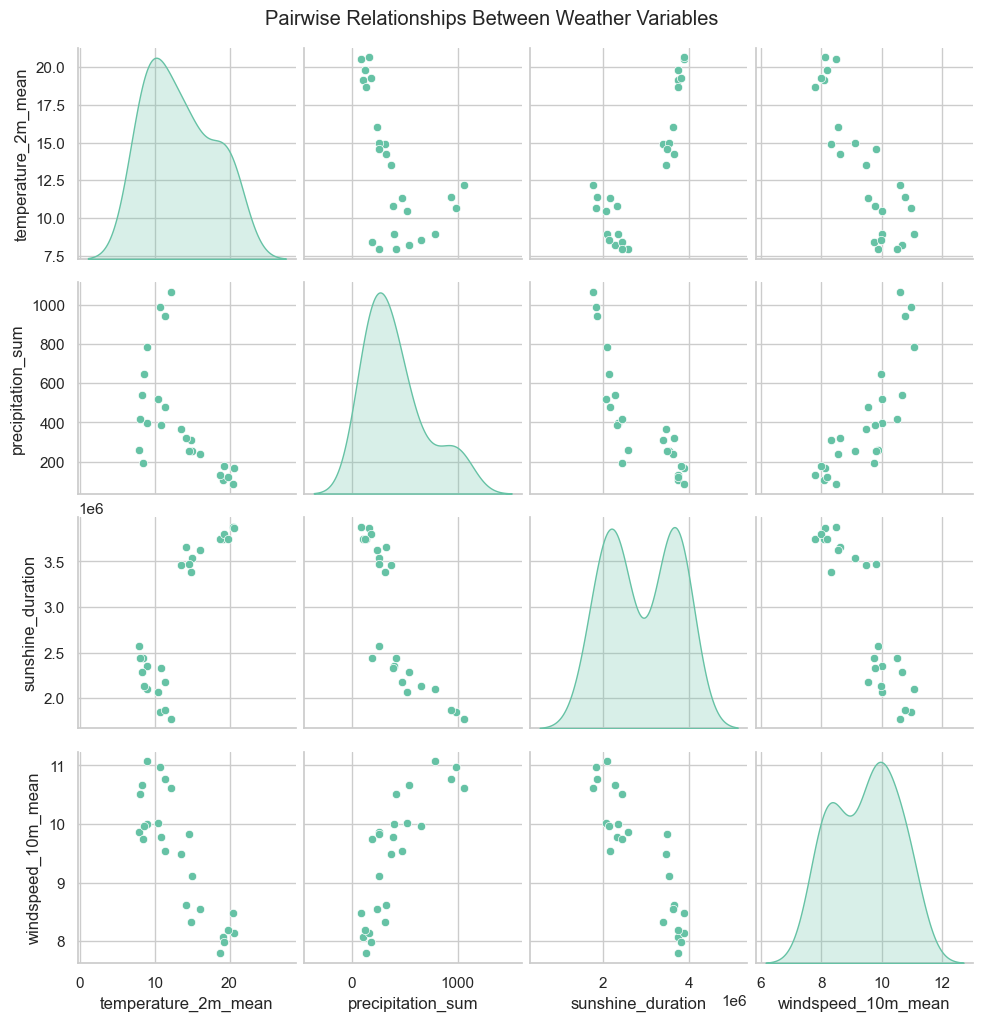

In [11]:
sns.pairplot(north_weather, diag_kind="kde")
plt.suptitle("Pairwise Relationships Between Weather Variables", y=1.02)
plt.show()

## Conclusions


Our initial exploratory analysis, focused on the `Ultimos 12 meses_N2024.csv` prepared dataset, has revealed a critical, overarching trend that will serve as the foundation for our subsequent modeling.

The plot of "Average Median Prices per Quarter" from Q4 2019 to Q1 2025 demonstrates:

Time is the Strongest Factor: There is a powerful, consistent, and positive temporal trend in housing prices. From Q4 2019 to Q1 2025, average median prices have risen from ~€760 to ~€1205 (a ~60% increase) with almost no volatility.

This finding is the most important conclusion from your EDA. It establishes a baseline: any model we build must account for this time-based trend first.

### Implications for Modeling

This EDA finding is crucial for the next step - data modeling. We plan to merge the three datasets (Prices, Quarterly Weather, Income) into a single, comprehensive DataFrame. The "keys" for this merge will be the Region and the Time (Quarter). With the new merged DataFrame we will be able to investigate the correlation between price and variables like mean_temp, sunshine_duration, and income. We also understand that the weather, for example, is not the only factor that may describe the house prices pattern, but unfortunately we do not have the relevant dataset to include the factor of the job market. 

### The Question to be answered

After controlling for the strong upward trend in prices over time, do local weather patterns and income levels show any statistically significant impact on housing prices?